In [1]:
%matplotlib inline
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import random
import subprocess
import shutil
import os

In [53]:
# if you want to visualize predictions:
import pilotnet as p
import tensorflow as tf
from tensorflow.keras.models import load_model

Point the following directory locations to the data you have collected from your RACECAR.

You should create `dest_img_dir` beforehand, and install `ffmpeg` on your system.

In [9]:
# saved csv from car
driving_data = "../data_and_models/inference/results_04_19_18_41/results_04_19_18_41.csv"

# directory location of car images
parent_dir = os.path.dirname(driving_data) + os.path.sep

# write imgs to folder
dest_img_dir = "../vizbw/"

output_video_location = "../bw_inference.mp4"

if not(os.path.exists(dest_img_dir) and os.path.isdir(dest_img_dir)):
    raise ValueError("create " + dest_img_dir)
if os.path.exists(output_video_location):
    raise ValueError("this will overwrite " + output_video_location)

In [10]:
imgs = []
ngls = []

with open(driving_data) as fh:
    for line in fh:
        l = line.split(',')
        img = l[0]
        imgs.append(parent_dir + img)
        ngl = l[1]
        ngl = float(ngl)
        ngls.append(ngl)
        
print(len(imgs), len(ngls))

2147 2147


Text(0.5, 1.0, 'steering angles')

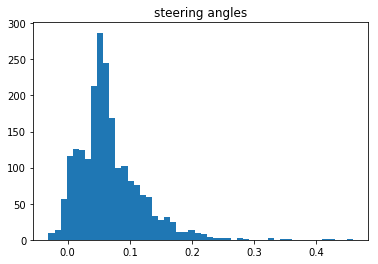

In [11]:
plt.hist(ngls, bins=50);
plt.gca().set_title("steering angles")

In [12]:
# overlays an angle as a red dot on top of a green bar

def viz_angle(idx, img, angle, ground_truth=None):
    
    ### 
    ### TODO: add separate visualization for ground_truth
    ###
    
    height, width = img.shape[0], img.shape[1]
    bar_height_px = int(0.8 * height)
    bar_left_px   = int(0.2 * width)
    bar_right_px  = int(0.8 * width)
    
    # visualize bar
    cv.line(img, (bar_left_px, bar_height_px), (bar_right_px, bar_height_px), (0,255,0), thickness=8)
    
    # visualize center line
    bar_length_px      = bar_right_px - bar_left_px
    bar_half_length_px = int(bar_length_px / 2.)
    bar_center_px      = bar_half_length_px + bar_left_px
    centerline_hfht_px = 20
    cv.line(img, (bar_center_px, bar_height_px - centerline_hfht_px), 
            (bar_center_px, bar_height_px  + centerline_hfht_px),
            (0,0,0), thickness=2)

    # visualize angle
    # NOTE: positive servo angles turn left, negative-right. Here, flip the sign for visualization
    px_offset          = int(bar_half_length_px * angle) * -1
    loc                = (bar_center_px + px_offset, bar_height_px)
    cv.circle(img, loc, 4, (0,0,255), thickness=15)
    
    # report angle and frame ID
    answer = "Angle: {:+06.2f}, image {:05d}".format(angle, idx)
    font = cv.FONT_HERSHEY_SIMPLEX
    cv.putText(img,answer,(bar_left_px, bar_height_px + 35), font, 0.45,(255,255,255),1,cv.LINE_AA)
    
    return img

In [13]:
def split_lcr(image, width=320, height=240):
    left   = image[0:height, 0:width, :]
    center = image[0:height, width:(width*2), :]
    right  = image[0:height, (width*2):(width*3), :]
    return (left,center,right)

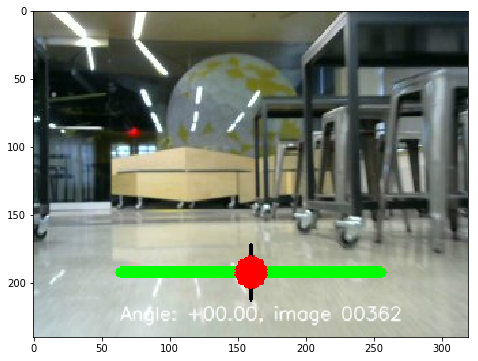

In [48]:
idx = random.randint(0,len(imgs)-1)

img = cv.imread(imgs[idx])

# to visualize trainingdata:
#img = split_lcr(img)[1]

result= viz_angle(idx, np.copy(img), ngls[idx])

fig,ax = plt.subplots()
ax.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
fig.set_size_inches(8,6)

In [50]:
# optional - visualize predictions
model = load_model("./bw0/bw_04_19_17_54_006.h5")

In [51]:
if os.listdir(dest_img_dir) != []:
    raise ValueError("destination directory not empty ", dest_img_dir)

In [54]:
TRAINING = False
PREDICT  = True

offset_idx = 195
ending_idx = 2147 - 187

# write images with visualized angles (NOTE: overwrites any existing images)
for idx, (imgfn, ngl) in enumerate(zip(imgs, ngls)):
    if idx < offset_idx:
        continue
    if idx > ending_idx:
        break
    
    if idx % 300 == 0:
        print(idx)
    img = cv.imread(imgfn)
    
    if TRAINING:
        #visualize groundtruth for training data
        img = split_lcr(img)[1]
    if PREDICT:
        # predict using the loaded model
        crop = p.preprocess(img)
        ngl = model.predict(np.array([crop]))[0][0]
    
    viz = viz_angle(idx, img, ngl)
    output_fn = dest_img_dir + "{:05d}.jpg".format(idx)
    cv.imwrite(output_fn, viz)

300
600
900
1200
1500
1800


In [55]:
#save video (NOTE: overwrites any existing video with the same name
ffmpeg = """ffmpeg -y -framerate 30 -pattern_type glob -i '*.jpg' -c:v libx264 -profile:v high -crf 26 -pix_fmt yuv420p {}"""

curdir = os.getcwd()
try:
    video = ffmpeg.format(output_video_location)
    os.chdir(dest_img_dir)
    subprocess.call(video, shell=True)
finally:
    os.chdir(curdir)

If you want to visualize the training data folder, this is an easy convenience function

In [15]:
USE_RANGE = True
MIN = 5000
MAX = 8000

# copy all files over to dest_img_dir from training dir, changing to a sequential order from dates
for idx, (imgfn, ngl) in enumerate(zip(imgs, ngls)):
    if USE_RANGE:
        if idx < MIN or idx > MAX:
            continue
    # dest_img_dir/00000001.jpg
    dest = "{}{:08d}.jpg".format(dest_img_dir, idx)
    shutil.copy2(imgfn, dest)